<a href="https://colab.research.google.com/github/luisfernandessaucedosouza/Aquisicao_Imovel/blob/main/imovel_analitico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
# As primeiras linhas de código tratam de importar ambas bibliotecas
import pandas as pd
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt


# Definir função que recaba os parâmetros taxa de juros parcelas e saldo devedor inicial
def sac(i,N,SD0):

    # Criar Data Frame com colunas de juros amortização e saldo devedor
    df = pd.DataFrame(columns=['Juros','Amortização','Parcela','Saldo Devedor'],index=range(N+1))

    # Declarar a primeira linha do saldo com o saldo devedor inicial
    df['Saldo Devedor'][0] = SD0

    # Declarar a amortização constante do SAC
    df['Amortização'][1:] = SD0/N

    # Calcular as demais linhas baseado na fórmula do SAC
    for n in df.index[1:]:
        df['Juros'][n] = round(df['Saldo Devedor'][n-1]*i,2)
        df['Parcela'][n] = df['Juros'][n]+df['Amortização'][n]
        df['Saldo Devedor'][n] = df['Saldo Devedor'][n-1] - df['Amortização'][n]

    # Aqui ajustamos a última parcela caso tenha valor residual devido ao arredondamento
    df['Parcela'][N] += df['Saldo Devedor'][N]
    df['Saldo Devedor'][N] -= df['Saldo Devedor'][N]

    return df

In [60]:
valor_do_imovel = 500000.00
entrada = 100000.00
taxa_financiamento_anual = 0.0942
taxa_aluguel_anual = 0.04
rendimento_investimentos_anual = 0.08
tempo_anos = 30

def taxa_aa_para_am(i):
    '''
    Função recebe uma taxa de juros anual
    e retorna a taxa mensal equivalente.
    '''
    return (1.+i)**(1./12.)-1.

valor_do_financiamento = valor_do_imovel - entrada
taxa_financiamento = taxa_aa_para_am(taxa_financiamento_anual)
taxa_aluguel = taxa_aa_para_am(taxa_aluguel_anual)
rendimento_investimentos = taxa_aa_para_am(rendimento_investimentos_anual)
tempo = tempo_anos * 12

In [61]:
# Passando os parâmetros declarados para a função sac
financiar = sac(
    taxa_financiamento,
    tempo,
    valor_do_financiamento
)

# Adicionando coluna de patrimônio e juros
financiar['Patrimônio - Imóvel'] = financiar['Amortização'].cumsum() + entrada
financiar['Custo - Juros'] = financiar['Juros'].cumsum()

In [ ]:
# Inicializamos um DataFrame vazio
alugar = pd.DataFrame(index=range(tempo+1))

# Calculamos o valor do aluguel
aluguel = round((valor_do_imovel)*taxa_aluguel,2)
alugar['Aluguel'] = aluguel
# Aluguel no tempo zero é igual a zero
alugar['Aluguel'][0] = 0.0

# Aqui calculamos o custo com aluguel como o somatório
# de todos os valores pagos
alugar['Custo - Aluguel'] = alugar['Aluguel'].cumsum()

# O aporte em aplicações financeiras se da pela diferença
# entre o que seria pago de financiamento no exemplo anterior
# e o valor do aluguel do imóvel
alugar['Aportes'] = financiar['Parcela'] - aluguel

# E o aporte inicial é o valor que estaria disponível como entrada
alugar['Aportes'][0] = entrada
# Aqui a variável é basicamente inicializada
alugar['Patrimônio'] = alugar['Aportes']

# O patrimônio é realmente calculado neste laço
for n in alugar.index[1:]:
    alugar['Patrimônio'][n] = alugar['Aportes'][n] + alugar['Patrimônio'][n-1] * (1. + rendimento_investimentos)

# Por fim, a fração Principal é tida como o somatório de todos os aportes
alugar['Patrimônio - Principal'] = alugar['Aportes'].cumsum()
# E os rendimentos são obtidos pela seguinte subtração
alugar['Patrimônio - Rendimentos'] = alugar['Patrimônio'] - alugar['Patrimônio - Principal']

alugar['Saldo devedor'] = 0
alugar['Saldo devedor'][0] = valor_do_financiamento
for n in alugar.index[1:]:
    alugar['Saldo devedor'][n] = alugar['Saldo devedor'][0] - n*(alugar['Saldo devedor'][0]/tempo)



In [63]:
#definindo constantes do problema
valor_do_imovel = 500000.00
entrada = 100000.00
taxa_financeamento_anual = 0.0942
taxa_aluguel_anual = 0.04
rendimento_investimentos_anual = 0.08
tempo_anos = 30

#transformando constantes
def taxa_aa_para_am(i):
    '''
    Função recebe uma taxa de juros anual
    e retorna a taxa mensal equivalente.
    '''
    return (1.+i)**(1./12.)-1.

valor_do_financiamento = valor_do_imovel - entrada
taxa_financiamento = taxa_aa_para_am(taxa_financeamento_anual)
taxa_aluguel = taxa_aa_para_am(taxa_aluguel_anual)
rendimento_investimentos = taxa_aa_para_am(rendimento_investimentos_anual)
parcelas = tempo_anos * 12

0.0075301687448090515

In [64]:
#definindo variáveis
t = sp.Symbol("t", real=True)

amortizacao = valor_do_financiamento/parcelas

saldo_devedor = valor_do_financiamento - t*amortizacao

juros = taxa_financiamento*saldo_devedor

prestacoes = juros + amortizacao

aluguel = taxa_aluguel*valor_do_imovel

k = prestacoes - aluguel

#definindo montante em função do tempo
S = sp.Function('S')

#resolvedo edo que carcteriza o problema
St = sp.dsolve(sp.Derivative(S(t),t)-rendimento_investimentos*S(t)-k, S(t), ics={S(0): entrada})

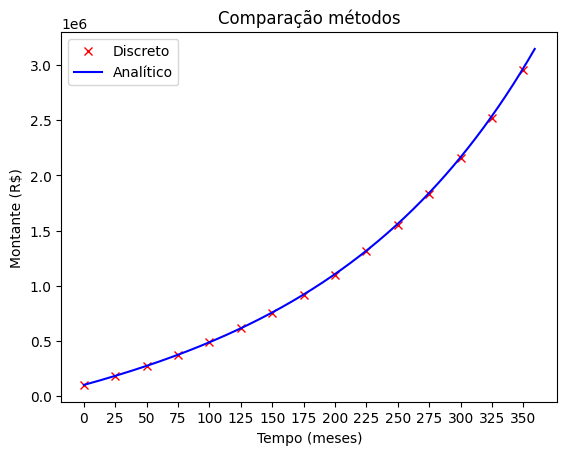

In [95]:
#comparar graficamente os métodos
ax = plt.subplot()

#definir plot do método discreto
ax.plot(np.arange(0, 361, 25), alugar['Patrimônio'][np.arange(0, 361, 25)], 'x', color='red', label= 'Discreto')
ax.set_xticks(np.arange(0, 361, 25))

#definir plot do método analítico
ax.plot(np.arange(360),  [St.subs(t,i).rhs.evalf() for i in range(360)] , 'b', label= 'Analítico')

ax.set_xlabel('Tempo (meses)')
ax.set_ylabel('Montante (R$)')
ax.set_title('Comparação métodos')

ax.legend()

In [80]:
delta = abs(alugar['Patrimônio'][360]-St.subs(t,360).rhs.evalf())

erro_percentual = delta/alugar['Patrimônio'][360]

erro_percentual

0.00677510623638547